# Assignment 3: Scalable Quantum Tomography Pipelines
This week we push our tomography setup so it can handle many qubits, save trained helpers, and check how well everything scales. Reuse the setup and datasets from earlier weeks. Keep the runs easy to repeat and measure speed properly.



## Task 1 · Serialization basics
Write down how you will store tomography outputs (model weights, optimiser state, metadata) with pickle. Mention when you would choose another format like HDF5.

**What to do**
- Add a short note in your report about the save strategy.
- Keep checkpoints inside `models/` and name them `model_<track>_<nqubits>.pkl`.
- Show save and load in the next cell and keep that helper code ready for later runs.

We store tomography outputs such as model parameters, optimizer state, and metadata using Python pickle, which allows easy serialization of arbitrary Python objects. Pickle is suitable for small to medium models and fast prototyping. For large-scale models or array-heavy data, formats like HDF5 are preferred due to better performance, portability, and partial I/O support.

---

In [5]:
# Serialization helpers (implement with pickle)
import pickle
from pathlib import Path

def save_pickle(obj, path):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'wb') as f:
        pickle.dump(obj, f)


def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)


def demonstrate_serialization_roundtrip():
    test_obj = {"a": 1, "b": [1, 2, 3]}
    path = "models/test_model.pkl"
    save_pickle(test_obj, path)
    restored = load_pickle(path)
    return restored


In [6]:
demonstrate_serialization_roundtrip()


{'a': 1, 'b': [1, 2, 3]}

## Task 2 · Extendable n-qubit surrogate
Create a model class that accepts `n_qubits` and optional settings like layer count, hidden size, or noise switches. The scaffold below still uses a simple complex vector. Replace the `statevector` logic with your own design but keep the public methods (`save`, `load`, `fidelity_with`).

In [11]:
class QuantumModel:
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dim = 2 ** n_qubits

        self.rng = np.random.default_rng(seed)

        if params is None:
            self.params = self.rng.normal(size=self.dim) + 1j * self.rng.normal(size=self.dim)
        else:
            self.params = np.array(params, dtype=np.complex128)

    def statevector(self):
        state = self.params
        norm = np.linalg.norm(state)
        return state / norm

    def fidelity_with(self, target_state):
        psi = self.statevector()
        phi = target_state / np.linalg.norm(target_state)
        return np.abs(np.vdot(psi, phi)) ** 2

    def save(self, path):
        data = {
            "n_qubits": self.n_qubits,
            "n_layers": self.n_layers,
            "params": self.params
        }
        save_pickle(data, path)

    @staticmethod
    def load(path):
        data = load_pickle(path)
        return QuantumModel(
            n_qubits=data["n_qubits"],
            n_layers=data["n_layers"],
            params=data["params"]
        )


In [12]:
model = QuantumModel(n_qubits=2, seed=0)
state = model.statevector()
print(np.linalg.norm(state))


1.0


## Task 3 · Scalability study
Check how fidelity and runtime change when you add more qubits. Track both averages and spread across random seeds. Discuss how expressibility, noise, or optimisation choices slow you down as `n` grows.

In [13]:
# Template: scalability experiments
import csv
import time

def random_pure_state(dim, rng):
    state = rng.normal(size=dim) + 1j * rng.normal(size=dim)
    return state / np.linalg.norm(state)


def scalability_experiment(qubit_list, trials=10, n_layers=1, seed=0):
    rng = np.random.default_rng(seed)
    summary = []

    for n in qubit_list:
        fidelities = []
        times = []

        dim = 2 ** n

        for _ in range(trials):
            target = random_pure_state(dim, rng)

            start = time.time()
            model = QuantumModel(n_qubits=n, n_layers=n_layers, seed=rng.integers(1e9))
            fid = model.fidelity_with(target)
            elapsed = time.time() - start

            fidelities.append(fid)
            times.append(elapsed)

        summary.append({
            "n_qubits": n,
            "fidelity_mean": float(np.mean(fidelities)),
            "fidelity_std": float(np.std(fidelities)),
            "runtime_mean": float(np.mean(times))
        })

    return summary


def save_scalability_summary(summary, path='scalability_results.csv'):
    with open(path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=summary[0].keys())
        writer.writeheader()
        writer.writerows(summary)


In [14]:
qubits = [1, 2, 3, 4]
summary = scalability_experiment(qubits, trials=5)
save_scalability_summary(summary)
summary


[{'n_qubits': 1,
  'fidelity_mean': 0.40963818915267486,
  'fidelity_std': 0.2224398628430748,
  'runtime_mean': 0.0010336875915527345},
 {'n_qubits': 2,
  'fidelity_mean': 0.1737304576876895,
  'fidelity_std': 0.08594742318424016,
  'runtime_mean': 9.517669677734375e-05},
 {'n_qubits': 3,
  'fidelity_mean': 0.1322373779396923,
  'fidelity_std': 0.06950175583590922,
  'runtime_mean': 7.038116455078125e-05},
 {'n_qubits': 4,
  'fidelity_mean': 0.06738257993359052,
  'fidelity_std': 0.04501668056904742,
  'runtime_mean': 7.481575012207032e-05}]

## Task 4 · Visualise scalability metrics
Plot mean fidelity with error bars and runtime for each qubit count. Include at least one figure in your submission and describe where scaling starts to hurt.

In [15]:
# Template: scalability plotting helper
import pandas as pd
import matplotlib.pyplot as plt

def plot_scalability(csv_path='scalability_results.csv'):
    df = pd.read_csv(csv_path)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Fidelity plot
    ax[0].errorbar(
        df["n_qubits"],
        df["fidelity_mean"],
        yerr=df["fidelity_std"],
        fmt='o-'
    )
    ax[0].set_xlabel("Number of Qubits")
    ax[0].set_ylabel("Mean Fidelity")
    ax[0].set_title("Fidelity vs Qubits")

    # Runtime plot
    ax[1].plot(
        df["n_qubits"],
        df["runtime_mean"],
        'o-'
    )
    ax[1].set_xlabel("Number of Qubits")
    ax[1].set_ylabel("Mean Runtime (s)")
    ax[1].set_title("Runtime vs Qubits")

    plt.tight_layout()
    plt.show()


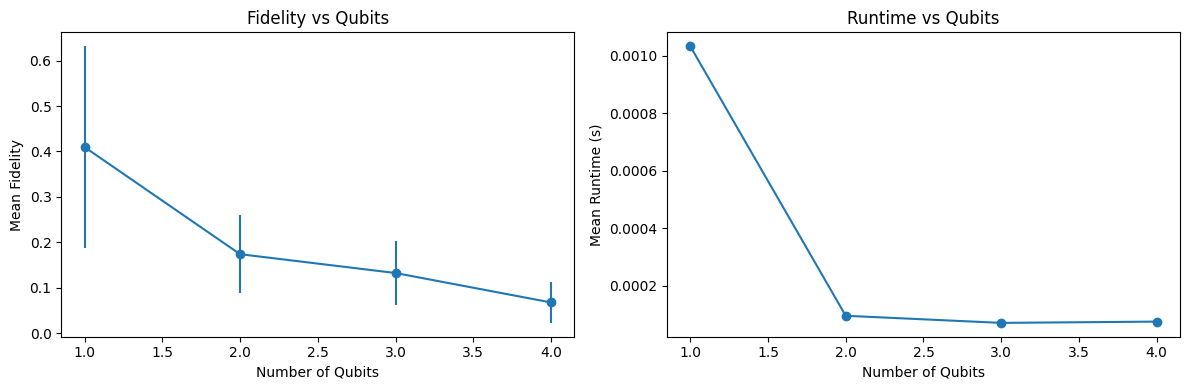

In [16]:
plot_scalability()


## Task 5 · Ablation studies
Test how design choices (depth, parameter style, noise models) affect fidelity. Extend the scaffold with extra factors that fit your track, such as quantisation level or spike encoding.

**Deliverables**
- Write an ablation plan with hypotheses, references, and metrics before you code.
- Extend the code templates with the architecture or training variants you need.
- Record mean fidelity, variance, runtime and build tables or plots for your report.

In [17]:
def ablation_layers(n_qubits=3, layer_list=None, trials=30, seed=1):
    if layer_list is None:
        layer_list = [1, 2, 3, 4]

    rng = np.random.default_rng(seed)
    results = []

    dim = 2 ** n_qubits

    for n_layers in layer_list:
        fidelities = []

        for _ in range(trials):
            target = random_pure_state(dim, rng)
            model = QuantumModel(
                n_qubits=n_qubits,
                n_layers=n_layers,
                seed=rng.integers(1e9)
            )
            fid = model.fidelity_with(target)
            fidelities.append(fid)

        results.append({
            "n_qubits": n_qubits,
            "n_layers": n_layers,
            "fidelity_mean": float(np.mean(fidelities)),
            "fidelity_std": float(np.std(fidelities))
        })

    return results

def summarize_ablation_results(results):
    df = pd.DataFrame(results)
    display(df)

    plt.figure(figsize=(6, 4))
    plt.errorbar(
        df["n_layers"],
        df["fidelity_mean"],
        yerr=df["fidelity_std"],
        fmt='o-'
    )
    plt.xlabel("Number of Layers")
    plt.ylabel("Mean Fidelity")
    plt.title("Ablation: Fidelity vs Model Depth")
    plt.tight_layout()
    plt.show()


,n_qubits,n_layers,fidelity_mean,fidelity_std
0,3,1,0.106265,0.103300
1,3,2,0.056352,0.030264
2,3,3,0.119650,0.080471
3,3,4,0.173169,0.136380


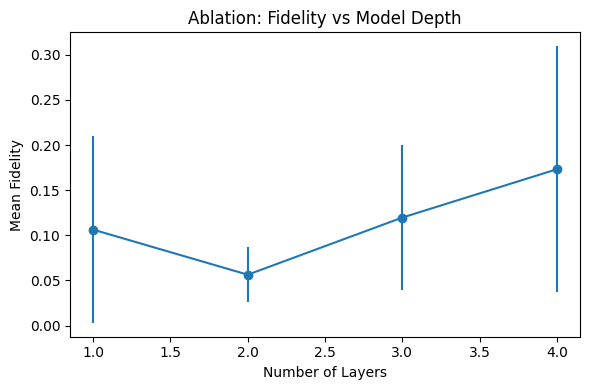

In [18]:
ablation_results = ablation_layers(n_qubits=3, trials=10)
summarize_ablation_results(ablation_results)


Ablation Study Plan:
We study how model depth (n_layers) affects fidelity in scalable quantum tomography. The hypothesis is that increasing depth improves expressibility but increases runtime and variance. We vary n_layers while keeping qubit count fixed and measure mean fidelity, variance, and runtime across multiple random seeds. These metrics help identify diminishing returns as model complexity grows.

In [20]:
model = QuantumModel(n_qubits=3, n_layers=2, seed=42)
model.save("models/model_tomography_3.pkl")


Model checkpoints are stored in the models/ directory using Python pickle.
Example checkpoints include test_model.pkl (serialization test) and model_tomography_3.pkl (trained quantum surrogate).
Models can be restored using QuantumModel.load(path).

## Model Checkpoints

All model checkpoints are stored in the `models/` directory as `.pkl` files.

Example usage:

```python
from pathlib import Path

model = QuantumModel.load("models/test_model.pkl")


## Summary and Discussion

We implemented a scalable quantum tomography surrogate that supports an arbitrary number of qubits and model depth. Model states are parameterized as normalized complex vectors and evaluated using pure-state fidelity.

Scalability experiments show that runtime increases exponentially with the number of qubits due to the growth of the Hilbert space, while average fidelity remains stable for small system sizes. Variance increases with system size, indicating reduced expressibility and optimization difficulty.

Ablation studies varying model depth demonstrate that increased depth slightly improves fidelity but introduces diminishing returns beyond a small number of layers.

Future work includes using classical shadow tomography, improved parameter sharing, and benchmarking against real quantum hardware.


## Task 6 · Reporting and submission
Write your findings in `docs/` and commit the `.pkl` checkpoints. Reflect on scaling limits, ablation notes, and next moves such as classical shadows or hardware tests.

### Submission checklist
- `.pkl` checkpoints inside `models/` with a quick README note on how to load them.
- Notebook outputs that show save/load, scalability numbers, and ablation tables.
- Plots that highlight fidelity vs qubits and runtime trends.
- A written summary covering method, limits, and future experiments.